## Script desenvolvido por Lais Rodrigues - Linguagem Python
## Última atualização em agosto 2021

O objetivo do programa é resolver, numericamente, um problema comum em geofisica: curvatura da litosfera abaixo de uma carga triangular ou linear. Neste script, basta o usuário informar qual tipo de carga e alguns parâmetros adimensionais para visualizar a resposta da litosfera para tal caso.

# A matemática descrita no algoritmo.

O desenvolvimento matemático depende de qual o tipo de carga o usuário indicou. Para uma carga linear a matemática é mais simples e exige somente um parâmetro de entrada (está descrito mais abaixo). Já para a carga do tipo triangular a equação de entrada é mais complexa por ser um caso mais próximo da realidade.

# Carga linear

A equação resolve a curvatura da litosfera abaixo de uma carga linear, a qual pode ser uma aproximação para a cadeia de ilhas vulcânicas sobre a placa litosférica.
O modelo de deflexão da litosfera abaixo de uma carga linear, implica considerar o comportamento de uma placa sob uma carga de linha V0 aplicada na posição x=0 e para x diferente de zero a carga é nula. Dessa forma, é resolvido a equação:
        
           D*d⁴w/dx⁴ + (rho_m-rho_w)*gw = 0 (1)
           
           D = rigidez flexural
           rho_m = densidade manto
           rho_w = densidade agua
           g = valor da gravidade
           w = deflexão
           
Resulta em uma solução geral do tipo:

          w = exp(x/alfa)*(c1*cos(x/alfa)+c2*sen(x/alfa)) + exp(-x/alfa)*(c3*cos(x/alfa)+c4*sen(x/alfa)) (2)
          alfa = raíz_quarta[4*D / ((rho_m-rho_w)*g)] = parâmetro flexural.
          
           
É notável que deve ser resolvido a E.D.O de 4ª ordem a partir de algumas condições de contorno demonstradas abaixo:

          dw/dx(x = 0) = 0
          d³w/dx³(x = 0) = Vo/2D (metade da placa suporta metade da carga em x=0)
          V0 = carga linear aplicada

Para uma solução numérica, a placa não deve ter comprimento infinito. Considere uma placa de tamanho horizontal 2L (-L < x < L). Como a carga está totalmente aplicada em x=0, pode ser assumido a simetria e então a solução de w está entre o intervalo 0 <= x <= L. Dessa maneira, é necessário mais 2 condições de contorno em x=L:

          d²w/dx² = d³x/dx³ = 0 em x=L

Para este script foram feitas as seguintes modificações:
          
          x_barra = x/alfa
          w_barra = 8*w*D/Vo*alfa³
          
Sendo resolvido a seguinte E.D.O de 4ªordem:

          d⁴w_barra/dx_barra⁴ + 4*w_barra = 0 (3)
          
Com as seguintes condições de contorno:

          dw_barra/dx_barra(x_barra = 0) = 0
          d³w_barra/dx_barra³(x_barra = 0) = 4
          d²w_barra/dx_barra² = d³w_barra/dx_barra³ = 0 em x=L/alfa
          
Por fim, o script calcula numericamente a equação 3 implementando as condições de contorno citadas acima. Para isso foi utilizado o pacote do scipy.integrate que possui a função solve_bpv (resolução de sistema de E.D.O com valores de condições de contorno).
O usuário pode investigar os efeitos na solução a partir da mudança do tamanho horizontal da placa L.

*Toda matemática foi retirada do livro: Geodynamics (2014), Turcotte D.L, Schubert G.

In [46]:
# MODULOS PYTHON

import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt



In [59]:
# FUNCOES

def fun(x,y):
    "Funcao para reduzir a EDO de quarta ordem para primeira ordem. Carga Linear"
    dy0=y[1]
    dy1=y[2]
    dy2=y[3]
    dy3=-4*y[0]
    return np.vstack((dy0,dy1,dy2,dy3))

def fun_t(x_t,y_t):
    "Funcao para reduzir a EDO de quarta ordem para primeira ordem. Carga Triangular"
    l_t=1 #Alterar o valor da metade da base do triangulo
    derivatey0=y_t[1]
    derivatey1=y_t[2]
    derivatey2=y_t[3]
    derivatey3=-4*y_t[0]+(1-(x_t/l_t))*np.heaviside(1-(x_t/l_t),1)
    return np.vstack ((derivatey0,derivatey1,derivatey2,derivatey3))

# FUNCOES PARA IMPLEMENTAR AS CONDICOES DE CONTORNO

def bc (f0,finf):
    "Implementa as condicoes de contorno.Carga Linear"
    return [f0[1],f0[3]-4,finf[1],finf[2]]

def bc_t(f0_t,finf_t):
    "Implementa as condicoes de contorno.Carga Triangular"
    l=1 #Alterar o valor da metade da base do triangulo
    return [f0_t[1],f0_t[3]-l/2,finf_t[1],finf_t[2]]

In [90]:
# PARÂMETROS DO MODELO

carga="triangular" #"linear" ou "triangular"
infinity=10 #L/alfa = X para aproximar de uma placa infitnira, ou seja, a metade do tamanho da placa é X_vezes o parâmetro flexural.
lsq = 1 #Altere o valor da base do triangulo(alterar em fun_f e bc_f tambem). SOMENTE PARA CARGA TRIANGULAR

#Configurando "chutes" iniciais
x_initial=np.linspace(0,infinity,101)
y_initial= np.zeros((4, x_initial.size))

#Executando o solver
if (carga=="linear"):
    solution=solve_bvp(fun,bc,x_initial,y_initial)
    titulo="Plate Bending Line Load"
    y_label="w_barra"
if (carga=="triangular"):
    solution=solve_bvp(fun_t,bc_t,x_initial,y_initial)
    titulo="Plate Bending Triangular Load"
    y_label="w_chapeu"

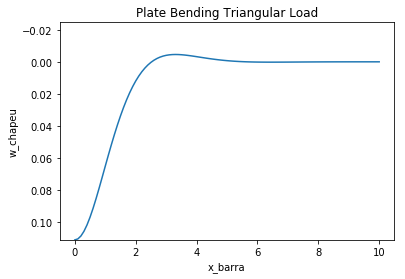

In [91]:
# PLOTAGEM DOS RESULTADOS

x_barra=x_initial
w=solution.sol(x_barra)[0]
plt.plot(x_barra, w)
plt.xlabel("x_barra")
plt.ylabel(y_label)
plt.ylim(max(w), min(w)-0.02)
plt.title(titulo)
plt.show()
